# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated every day starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated numbers of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [49]:
import requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate

pd.set_option('display.max_rows', 6)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10,
#                      'axes.labelweight': 'bold',
                     'figure.figsize': (6, 5)})

In [6]:
params = {'function': 'FX_DAILY',
          'from_symbol': 'CAD',
          'to_symbol': 'USD',
          'outputsize': 'full',
          'apikey': os.environ['ALPHA_API']}
url = "https://www.alphavantage.co/query"
response = requests.get(url, params)

json_data = response.json()
    
# Check if the request was successful, if not raise an
# exception
if 'Error Message' in list(json_data.keys()):    
    raise Exception("Request failed.")

# Create the pandas dataframe (see: pd.read_json() )
data = pd.DataFrame(json_data[list(json_data.keys())[1]]).\
transpose().apply(pd.to_numeric).reset_index()

data.columns = ['date', 'open', 'high', 'low', 'close']
data.date = pd.to_datetime(data.date)

data.head()

,date,open,high,low,close
0,2020-05-20,0.7169,0.7183,0.7166,0.7174
1,2020-05-19,0.7168,0.7210,0.7154,0.7172
2,2020-05-18,0.7090,0.7173,0.7089,0.7173
3,2020-05-15,0.7114,0.7132,0.7079,0.7081
4,2020-05-14,0.7089,0.7124,0.7068,0.7117


In [7]:
data.head()

,date,open,high,low,close
0,2020-05-20,0.7169,0.7183,0.7166,0.7174
1,2020-05-19,0.7168,0.7210,0.7154,0.7172
2,2020-05-18,0.7090,0.7173,0.7089,0.7173
3,2020-05-15,0.7114,0.7132,0.7079,0.7081
4,2020-05-14,0.7089,0.7124,0.7068,0.7117


## 3. Explore the dataset

## 4. Initial thoughts


## 5. Wrangling

In [8]:
# the following functions are borrowed from https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb
# Custom functions
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})


def ts_predict(input_data, model, n=20, responses=1):
    predictions = []
    n_features = input_data.size
    for _ in range(n):

        predictions = np.append(predictions,
                                model.predict(input_data.reshape(1, -1)))  # make prediction
        input_data = np.append(predictions[-responses:],
                               input_data[:n_features-responses])  # new input data
    return predictions.reshape((-1, responses))


def plot_ts(ax, df_train, df_test, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(df_test[col], '--', c=col_cycle[i], label = f'Validation {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+1)
    ax.set_title(f"Train Shape = {len(df_train)}, Validation Shape = {len(df_test)}",
                fontsize=16)
    ax.set_ylabel(df_train.columns[0])

        
def plot_forecast(ax, df_train, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], '-', c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+len(predictions))
    ax.set_title(f"{len(predictions)}-step forecast",
                    fontsize=16)
    ax.set_ylabel(response_cols)
    
def create_rolling_features(df, columns, windows=[6, 12]):
    for window in windows:
        df["rolling_mean_" + str(window)] = df[columns].rolling(window=window).mean()
        df["rolling_std_" + str(window)] = df[columns].rolling(window=window).std()
        df["rolling_var_" + str(window)] = df[columns].rolling(window=window).var()
        df["rolling_min_" + str(window)] = df[columns].rolling(window=window).min()
        df["rolling_max_" + str(window)] = df[columns].rolling(window=window).max()
        df["rolling_min_max_ratio_" + str(window)] = df["rolling_min_" + str(window)] / df["rolling_max_" + str(window)]
        df["rolling_min_max_diff_" + str(window)] = df["rolling_max_" + str(window)] - df["rolling_min_" + str(window)]

    df = df.replace([np.inf, -np.inf], np.nan)    
    df.fillna(0, inplace=True)
    return df

In [9]:
cad_to_usd = pd.merge(pd.DataFrame(pd.date_range(start='2018-01-01',
                                                 end=datetime.datetime.today()),
                                   columns=['date']),
                      data, how='left')

# data imputation with last observation carried over
cad_to_usd = cad_to_usd.fillna(method='ffill')

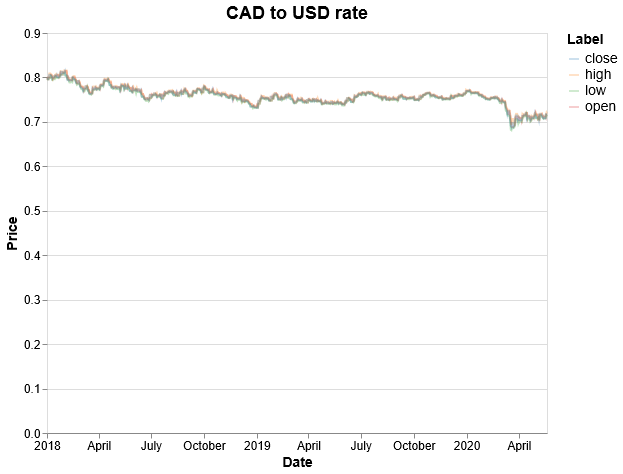

In [10]:
alt.Chart(
    pd.melt(cad_to_usd,
            id_vars=['date'],
            value_vars=['open', 'low', 'high', 'close'])
).encode(
    alt.X('date:T', title='Date'),
    alt.Y('value:Q', title='Price'),
    alt.Color('variable:N', title='Label')
).mark_line(
    opacity=0.3
).properties(
    height = 400,
    width = 500,
    title='CAD to USD rate'
)

In [11]:
data_lag = cad_to_usd[['date', 'close']].copy()
data_lag['y-1'] = data_lag['close'].shift(periods=1)

In [12]:
data_lag

,date,close,y-1
0,2018-01-01,0.7964,NaN
1,2018-01-02,0.7986,0.7964
2,2018-01-03,0.7972,0.7986
3,2018-01-04,0.8004,0.7972
4,2018-01-05,0.8059,0.8004
...,...,...,...
866,2020-05-16,0.7081,0.7081
867,2020-05-17,0.7081,0.7081
868,2020-05-18,0.7173,0.7081
869,2020-05-19,0.7172,0.7173


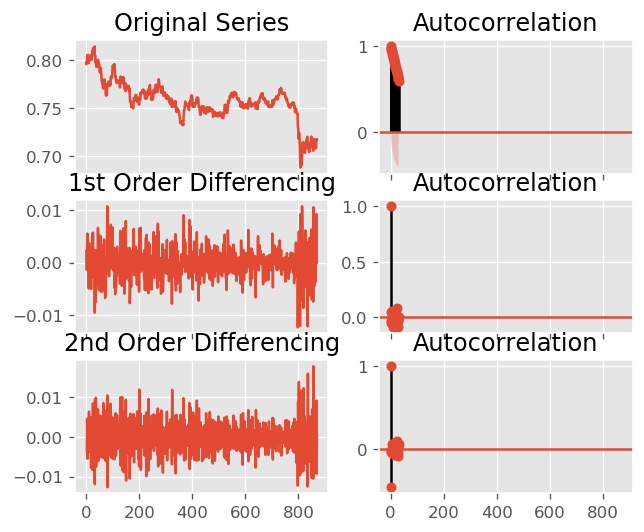

In [50]:
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# original series
df = cad_to_usd[['close']]
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['close']); axes[0, 0].set_title('Original Series')
plot_acf(df['close'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['close'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['close'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['close'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['close'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [41]:
model = pmdarima.auto_arima(df['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-7805.506, BIC=-7786.432, Time=1.631 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-7807.325, BIC=-7797.788, Time=0.308 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-7807.403, BIC=-7793.098, Time=0.435 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-7807.530, BIC=-7793.225, Time=0.704 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-7808.354, BIC=-7803.585, Time=0.349 seconds
Total fit time: 3.515 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  871
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3905.177
Date:                Wed, 20 May 2020   AIC                          -7808.354
Time:                        07:36:27   BIC                          -7803.585
Sample:                             0   HQIC                 

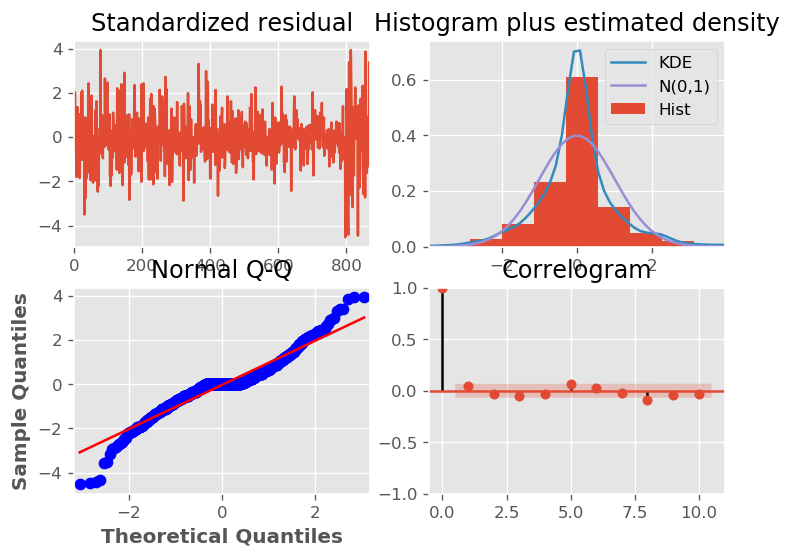

In [51]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [53]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pmdarima.auto_arima(df['close'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=-7548.535, BIC=-7524.756, Time=8.628 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=-5657.448, BIC=-5647.936, Time=0.924 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=-7381.343, BIC=-7362.320, Time=15.653 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=-6345.707, BIC=-6326.684, Time=7.644 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=-5643.362, BIC=-5638.606, Time=0.268 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=-7166.328, BIC=-7147.305, Time=1.517 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=-7433.384, BIC=-7404.849, Time=10.141 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=True]; AIC=-7549.133, BIC=-7520.599, Time=42.384 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=-7575.209, BIC=-7541.918, Time=41.665 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 2, 12); setting score to inf (at least one in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  871
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                3794.604
Date:                                 Wed, 20 May 2020   AIC                          -7575.209
Time:                                         07:51:11   BIC                          -7541.918
Sample:                                              0   HQIC                         -7562.463
                                                 - 871                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001   3.93e-05     -3.049      0.002      -0.000   -4.28e-05
ar.L1          0.9137      0.009    101.325      0.000       0.896       0.931
ma.L1          0.2544      0.029      8.885      0.000       0.198       0.311
ar.S.L12      -0.8384      0.534     -1.569      0.117      -1.885       0.209
ma.S.L12      -0.1419      0.527     -0.269      0.788      -1.176       0.892
ma.S.L24      -0.8431      0.502     -1.680      0.093      -1.827       0.140
sigma2      8.171e-06   3.77e-07     21.698      0.000    7.43e-06    8.91e-06
===================================================================================
Ljung-Box (Q):                      261.68   Jarque-Bera (JB):               189.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.43
Prob(H) (two-sided):                  0.56   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
split = 0.8
split_1 = int(data_lag.shape[0] * split)

train_valid, test = data_lag.iloc[: split_1], data_lag.iloc[split_1:]

split_2 = int(train_valid.shape[0] * split)
train, valid = train_valid.iloc[: split_2], train_valid.iloc[split_2:]

In [26]:
lag = 15  # you can vary the number of lagged features in the model
n_splits = 8  # you can vary the number of train/validation splits
response_col = ['close']
df_lag = lag_df(cad_to_usd[['close']], lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # define the model

cv = cross_validate(model,
                    X = df_lag.drop(columns=response_col),
                    y = df_lag[response_col[0]],
                    cv=tscv,
                    return_train_score=True)

pd.DataFrame({'split': range(n_splits),
              'train_r2': cv['train_score'],
              'validation_r2': cv['test_score']}).set_index('split')

,train_r2,validation_r2
split,,
0,0.990761,0.442822
1,0.993355,0.575149
2,0.992876,-0.115552
...,...,...
5,0.995799,0.807660
6,0.995635,0.908020
7,0.995491,-0.737252


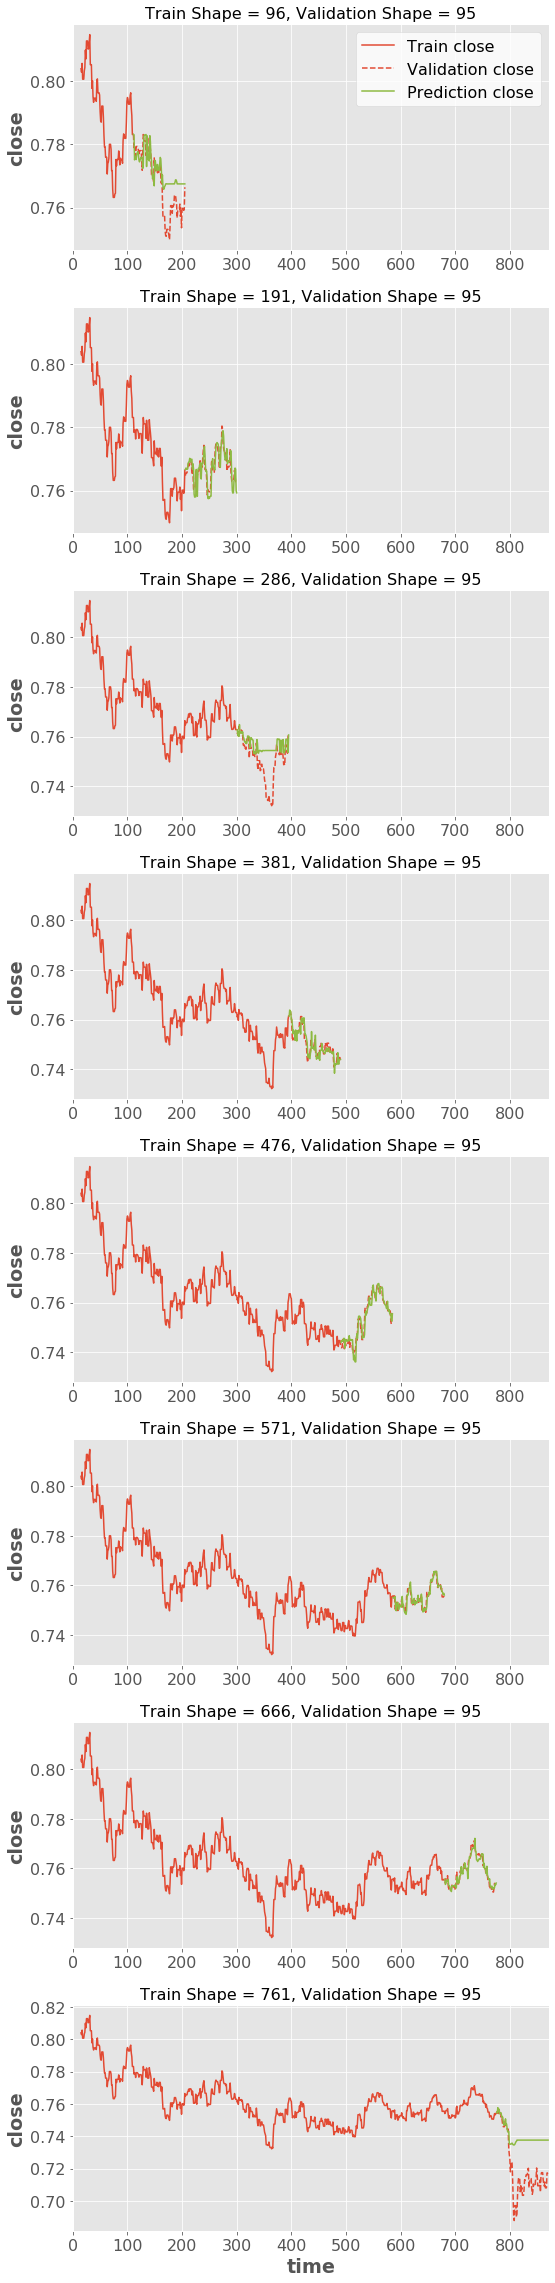

In [27]:
fig, ax = plt.subplots(n_splits, 1, figsize=(8,4*n_splits))
for i, (train_index, test_index) in enumerate(tscv.split(df_lag)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=response_col),
                                        df_train[response_col[0]])  # train model
    # Prediction loop
    predictions = model.predict(df_test.drop(columns=response_col))[:,None]

    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time')
fig.tight_layout()

## 6. Research questions



## 7. Data Analysis & Visualizations

## 8. Summary and conclusions
